Executing HJB solver
Executing Focker Planck solver
Iteration 1, Total Normalized Error: 0.638748
Executing HJB solver
Executing Focker Planck solver
Iteration 2, Total Normalized Error: 0.511806
Executing HJB solver
Executing Focker Planck solver
Iteration 3, Total Normalized Error: 0.410912
Executing HJB solver
Executing Focker Planck solver
Iteration 4, Total Normalized Error: 0.331050
Executing HJB solver
Executing Focker Planck solver
Iteration 5, Total Normalized Error: 0.267846
Executing HJB solver
Executing Focker Planck solver
Iteration 6, Total Normalized Error: 0.217711
Executing HJB solver
Executing Focker Planck solver
Iteration 7, Total Normalized Error: 0.177803
Executing HJB solver
Executing Focker Planck solver
Iteration 8, Total Normalized Error: 0.145941
Executing HJB solver
Executing Focker Planck solver
Iteration 9, Total Normalized Error: 0.120511
Executing HJB solver
Executing Focker Planck solver
Iteration 10, Total Normalized Error: 0.100365
Executing HJB solve

AttributeError: 'QuadContourSet' object has no attribute 'collections'

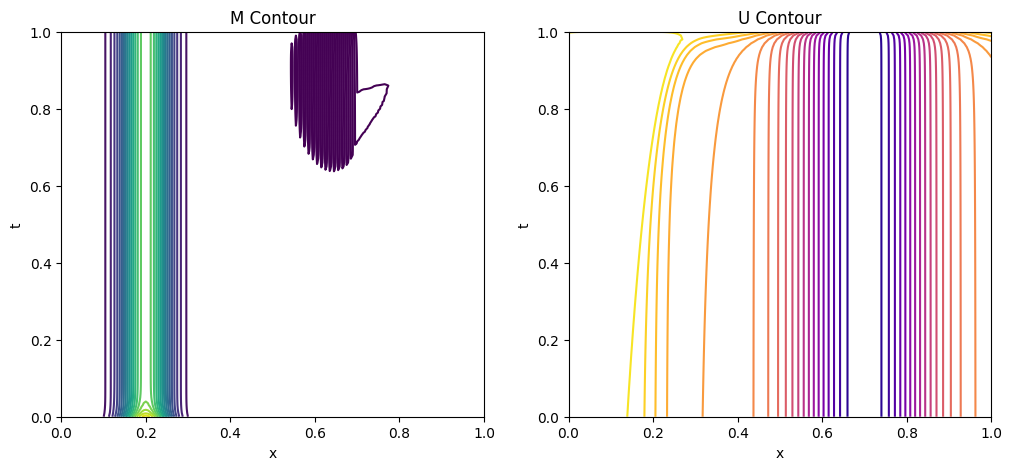

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation  # Import the animation module
import math
import numpy as np
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import scipy.sparse as sparse

# ... (Your existing functions: g, f_tilda, phi, m0, H_tilda, F, compute_jacobian_F, HJB_solver, FP_solver) ...
# --- Paste the definitions of g, f_tilda, ..., FP_solver here ---
def g(x):
	return 0

def f_tilda(M): # Corrected name to f_tilda
	return M/10

def phi(x):
	return -np.exp(-40*(x-0.7)**2)

def m0(x):
	return np.sqrt(300/np.pi)*np.exp(-300*(x-0.2)**2)

def H_tilda(p_backward, p_forward, m, beta, alpha, c0, c1):
	# Negative part of p_backward squared: (p₁²_−)
	p1_sq_neg = np.maximum(-p_backward, 0)**2
	
	# Positive part of p_forward squared: (p₂²_+)
	p2_sq_pos = np.maximum(p_forward, 0)**2
	
	# Combine terms and apply exponents
	H = ( (p1_sq_neg + p2_sq_pos) ** (beta / 2) ) / (beta * (c0 + c1 * m)**alpha)
	
	return H

def discrete_hamiltonian(p1, p2, mu, beta, c0, c1, alpha):
	return (1 / beta) * ((np.maximum(p1, 0) ** 2 + np.maximum(-p2, 0) ** 2) ** (beta / 2)) * (c0 + c1 * mu) ** alpha

def finite_diff_laplacian(U, h):
	"""
	Compute the finite difference approximation of the Laplacian.
	"""
	return (-2 * U + np.roll(U, 1) + np.roll(U, -1)) / h**2


# def F(U_n, U_np1, M_np1, nu, dt, h, alpha, beta, c0, c1, x_grid):
#     """
#     Compute the function F(U_n, U_np1, M_np1) for the discrete HJB equation.
#     """
#     # Compute finite differences
#     dU_dt = (U_np1 - U_n) / dt  # Backward Euler time derivative
#     laplacian_U = finite_diff_laplacian(U_n, h)  # Laplacian term
	
#     # Compute discrete gradients
#     grad_U_forward = (np.roll(U_n, -1) - U_n) / h
#     grad_U_backward = (U_n - np.roll(U_n, 1)) / h
	
#     # Compute Hamiltonian term
#     H_tilde = discrete_hamiltonian(grad_U_forward, grad_U_backward, M_np1, beta, c0, c1, alpha)
	
#     # Source term
#     g_vals = g(x_grid)  # g(x)
#     f0_vals = f_tilda(M_np1)  # f0(M_np1)
	
#     # Compute F
#     F_val = -dU_dt - nu * laplacian_U + H_tilde - (g_vals + f0_vals)
	
#     return F_val


def F(U_n, U_np1, M_np1, nu, dt, h, alpha, beta, c0, c1, x_grid):
	Nh = len(U_n)
	F = np.zeros(Nh)

	for i in range(Nh):
		# Spatial derivatives using finite differences, handling Neumann BC implicitly
		U_n_i = U_n[i]
		U_np1_i = U_np1[i]

		# Neumann Boundary Conditions Corrected (Version 2)
		if i == 0:  # Left boundary
			U_n_im1 = U_n[i]   #  U_{-1} = U_0 approximation
			U_n_ip1 = U_n[i+1] if i+1 < Nh else U_n[i] # For i=0, if Nh=1, then U_n_ip1 = U_n[0], else U_n[1]
		elif i == Nh - 1:  # Right boundary
			U_n_im1 = U_n[i-1]
			U_n_ip1 = U_n[i]   # U_{Nh} = U_{Nh-1} approximation
		else:  # Interior points (0 < i < Nh-1)
			U_n_im1 = U_n[i-1]
			U_n_ip1 = U_n[i+1]

		laplacian_U_n_i = -(2*U_n_i - U_n_ip1 - U_n_im1) / (h**2)

		p1_i = (U_n_ip1 - U_n_i) / h
		p2_i = (U_n_i - U_n_im1) / h

		# Discrete Hamiltonian (Example 2.1 from tutorial)
		mu_i = M_np1[i]
		H_tilde_val = (1.0/beta) * ((np.maximum(0, -p1_i)**2 + np.maximum(0, p2_i)**2)**(beta/2)) / ((c0 + c1*mu_i)**alpha)

		# **Corrected time derivative sign - Version 3*
		F[i] = (U_np1_i - U_n_i) / dt  + nu * laplacian_U_n_i - H_tilde_val + f_tilda(mu_i)

	return F


def compute_jacobian_F(U_n, M_np1, nu, dt, h, alpha, beta, c0, c1):
	Nh = len(U_n)
	jacobian = np.zeros((Nh, Nh))  # Initialize dense Jacobian matrix

	# Vectorized finite differences
	U_n_ip1_val = np.roll(U_n, -1)
	U_n_im1_val = np.roll(U_n, 1)

	# Boundary conditions handling (Neumann) - applied after roll for vectorized operations
	U_n_ip1_val[-1] = U_n[-1]  # U_{Nh} = U_{Nh-1} for right boundary (index Nh-1)
	U_n_im1_val[0] = U_n[0]    # U_{-1} = U_0 for left boundary (index 0)

	# Vectorized computation of p1, p2, and mu
	p1_i = (U_n_ip1_val - U_n) / h
	p2_i = (U_n - U_n_im1_val) / h
	mu_i = M_np1

	# Vectorized handling of positive and negative parts
	p1_neg = np.maximum(-p1_i, 0)  # p1^-
	p2_pos = np.maximum(p2_i, 0)   # p2^+

	# Vectorized computation of Hamiltonian terms
	factor = 1 / (c0 + c1 * mu_i)**alpha
	term = (p1_neg**2 + p2_pos**2)**((beta - 2) / 2)

	# Vectorized computation of Hamiltonian derivatives
	dH_dp1_val = -p1_neg * term * factor  # ∂H/∂p1 (only if p1 < 0)
	dH_dp2_val = p2_pos * term * factor   # ∂H/∂p2 (only if p2 > 0)

	# Vectorized Jacobian diagonal, upper and lower diagonals
	J_ii_diag = -(1/dt) - (2 * nu / (h ** 2)) - (1/h) * (dH_dp2_val - dH_dp1_val)
	J_i_ip1_diag = (nu / (h ** 2)) - (1/h) * dH_dp1_val
	J_i_im1_diag = (nu / (h ** 2)) + (1/h) * dH_dp2_val

	# Set diagonals in Jacobian matrix
	jacobian_diag_indices = np.arange(Nh)
	jacobian[jacobian_diag_indices, jacobian_diag_indices] = J_ii_diag

	if Nh > 1: # Avoid errors when Nh=1
		jacobian[jacobian_diag_indices[:-1], jacobian_diag_indices[1:]] = J_i_ip1_diag[:-1] # Upper diagonal (excluding last element)
		jacobian[jacobian_diag_indices[1:], jacobian_diag_indices[:-1]] = J_i_im1_diag[1:] # Lower diagonal (excluding first element)


	return jacobian

# def compute_jacobian_F(U_n, M_np1, nu, dt, h, alpha, beta, c0, c1):
#     Nh = len(U_n)
#     jacobian = np.zeros((Nh, Nh))  # Initialize dense Jacobian matrix
#     eps = 1e-12  # Small constant to prevent division by zero
	
#     for i in range(Nh):
#         if i == 0:  
#             U_n_im1_val = U_n[i]
#             U_n_ip1_val = U_n[i+1] if i+1 < Nh else U_n[i]
#         elif i == Nh - 1:  
#             U_n_im1_val = U_n[i-1]
#             U_n_ip1_val = U_n[i]
#         else:  
#             U_n_im1_val = U_n[i-1]
#             U_n_ip1_val = U_n[i+1]

#         # Compute finite differences
#         p1_i = (U_n_ip1_val - U_n[i]) / h
#         p2_i = (U_n[i] - U_n_im1_val) / h
#         mu_i = M_np1[i]
		
#         # **Handle Positive and Negative Parts**
#         p1_neg = np.maximum(-p1_i, 0)  # p1^-
#         p2_pos = np.maximum(p2_i, 0)   # p2^+

#         # Compute the discrete Hamiltonian term
#         factor = 1 / (c0 + c1 * mu_i)**alpha
#         term = (p1_neg**2 + p2_pos**2 + eps)**((beta - 2) / 2)
		
#         # Compute derivatives correctly
#         dH_dp1_val = -p1_neg * term * factor  # ∂H/∂p1 (only if p1 < 0)
#         dH_dp2_val = p2_pos * term * factor   # ∂H/∂p2 (only if p2 > 0)

#         J_ii = -(1/dt) - (2 * nu / (h ** 2)) - (1/h) * (dH_dp2_val - dH_dp1_val)
#         jacobian[i, i] = J_ii

#         if i + 1 < Nh:
#             J_i_ip1 = (nu / (h ** 2)) - (1/h) * dH_dp1_val
#             jacobian[i, i+1] = J_i_ip1

#         if i - 1 >= 0:
#             J_i_im1 = (nu / (h ** 2)) + (1/h) * dH_dp2_val
#             jacobian[i, i-1] = J_i_im1

#     return jacobian



def HJB_solver(U, M, beta, alpha, c0, c1, dt, h, Nh, Nt, nu, x):
	U_hat = np.copy(U)

	for n in range(Nt-1, -1, -1):
		U_hat_n = np.copy(U_hat[:, n+1])
		newton_iteration_count = 0
		while True:
			newton_iteration_count += 1
			U_hat_n_old = np.copy(U_hat_n)

			J = compute_jacobian_F(U_hat_n, M[:,n+1], nu, dt, h, alpha, beta, c0, c1)
			b = F(U_hat_n, U_hat[:,n+1], M[:,n+1], nu, dt, h, alpha, beta, c0, c1, x)


			J_sparse = csc_matrix(J)
			
			#delta_U_hat_n = np.linalg.solve(J, b) # Use dense solver solve instead of spsolve
			delta_U_hat_n = spsolve(J_sparse, b)

			U_hat_n -= delta_U_hat_n

			norm_diff = np.linalg.norm(U_hat_n - U_hat_n_old)
			newton_norm_factor = np.sqrt(Nh) # Correct norm factor to use Nh
			normalized_norm_diff = norm_diff / newton_norm_factor

			if normalized_norm_diff < 1e-12:
				#print(f"Newton converged after {newton_iteration_count} iterations for time step {Nt-1-n}, Normalized Norm Diff: {normalized_norm_diff:.10e}")
				break
			if newton_iteration_count > 100:
				print(f"Newton did not converge after {newton_iteration_count} iterations for time step {Nt-1-n}, Normalized Norm Diff: {normalized_norm_diff:.10e}")
				break

		U_hat[:,n] = U_hat_n

	return U_hat


def compute_jacobian_H(U_n, M_np1, h, alpha, beta, c0, c1):

	Nh = len(U_n)
	jacobian = np.zeros((Nh, Nh))  # Initialize dense Jacobian matrix

	# Vectorized finite differences
	U_n_ip1_val = np.roll(U_n, -1)
	U_n_im1_val = np.roll(U_n, 1)

	# Boundary conditions handling (Neumann) - applied after roll for vectorized operations
	U_n_ip1_val[-1] = U_n[-1]  # U_{Nh} = U_{Nh-1} for right boundary (index Nh-1)
	U_n_im1_val[0] = U_n[0]    # U_{-1} = U_0 for left boundary (index 0)

	# Vectorized computation of p1, p2, and mu
	p1_i = (U_n_ip1_val - U_n) / h
	p2_i = (U_n - U_n_im1_val) / h
	mu_i = M_np1

	# Vectorized handling of positive and negative parts
	p1_neg = np.maximum(-p1_i, 0)  # p1^-
	p2_pos = np.maximum(p2_i, 0)   # p2^+

	# Vectorized computation of Hamiltonian terms
	factor = 1 / (c0 + c1 * mu_i)**alpha
	term = (p1_neg**2 + p2_pos**2)**((beta - 2) / 2)

	# Vectorized computation of Hamiltonian derivatives
	dH_dp1_val = -p1_neg * term * factor  # ∂H/∂p1 (only if p1 < 0)
	dH_dp2_val = p2_pos * term * factor   # ∂H/∂p2 (only if p2 > 0)

	# Vectorized Jacobian diagonal, upper and lower diagonals
	J_ii_diag = (1/h) * (dH_dp2_val - dH_dp1_val)
	J_i_ip1_diag = - (1/h) * dH_dp1_val
	J_i_im1_diag = (1/h) * dH_dp2_val

	# Set diagonals in Jacobian matrix
	jacobian_diag_indices = np.arange(Nh)
	jacobian[jacobian_diag_indices, jacobian_diag_indices] = J_ii_diag

	if Nh > 1: # Avoid errors when Nh=1
		jacobian[jacobian_diag_indices[:-1], jacobian_diag_indices[1:]] = J_i_ip1_diag[:-1] # Upper diagonal (excluding last element)
		jacobian[jacobian_diag_indices[1:], jacobian_diag_indices[:-1]] = J_i_im1_diag[1:] # Lower diagonal (excluding first element)

	return jacobian


def FP_solver(U_hat, M, dt, h, Nh, Nt, nu, beta, alpha, c0, c1):
	M_hat = np.copy(M)

	for n in range(0, Nt):  # Forward time loop
		M_hat_n = np.copy(M_hat[:, n])  # Current time step
		b = M_hat_n / dt  # RHS vector

		# Compute the Jacobian matrix (dense)
		J = compute_jacobian_H(U_hat[:, n], M[:, n+1], h, alpha, beta, c0, c1)

		#print(J.T[:,1].sum(), J.T[:,2].sum(), J.T[1,:].sum(), J.T[2,:].sum())
		# Convert J to sparse CSC format and transpose
		J_sparse = sparse.csc_matrix(J)
		J_T_sparse = J_sparse.T

		# Construct sparse components
		identity = (1.0 / dt) * sparse.eye(Nh, format='csc')
		laplacian = (nu / h**2) * sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(Nh, Nh), format='csc')
		
		# Combine to form A using sparse operations
		A = identity + laplacian + J_T_sparse

		# Solve the sparse linear system
		M_hat_np1 = spsolve(A, b)

		# Assign to next time step
		M_hat[:, n+1] = M_hat_np1

	return M_hat





def fixed_point_solver(beta, c0, c1, alpha, sigma, theta, Nh_val=201, Nt_val=100, tol=2e-3):
	global Nh, Nt
	Nh = Nh_val
	Nt = Nt_val

	nu = (sigma**2) / 2
	dt = 1 / Nt
	h = 1 / Nh

	X = 1
	T = 1

	x_list = [X / (Nh - 1) * i for i in range(Nh)] # x_list and x remain with Nh points
	x = np.array(x_list)
	t = [T / Nt * i for i in range(Nt + 1)]

	# Corrected: M and U now have shape (Nh, Nt + 1)
	M = np.zeros((Nh, Nt + 1))
	for i in range(Nh): # Loop from 0 to Nh-1 (inclusive)
		M[i, 0] = m0(x[i])
	for j in range(Nt+1):
		M[:,j] = M[:,0]

	U = np.zeros((Nh, Nt + 1))
	for i in range(Nh): # Loop from 0 to Nh-1 (inclusive)
		U[i, Nt] = phi(x[i])
	for j in range(0, Nt):
		U[:,j] = U[:,Nt]


	# Lists to store M and U at each iteration
	M_history = []
	U_history = []

	iteration_count = 0
	while True:
		iteration_count += 1
		M_old, U_old = np.copy(M), np.copy(U)
		
		print("Executing HJB solver")
		U_hat = HJB_solver(U, M, beta, alpha, c0, c1, dt, h, Nh, Nt, nu, x)
		
		print("Executing Focker Planck solver")
		M_hat = FP_solver(U_hat, M, dt, h, Nh, Nt, nu, beta, alpha, c0, c1)
		M, U = (1 - theta) * M + theta * M_hat, (1 - theta) * U + theta * U_hat

		# Store M and U for animation
		M_history.append(np.copy(M))
		U_history.append(np.copy(U))

		error_M = np.linalg.norm(M - M_old, 'fro')
		error_U = np.linalg.norm(U - U_old, 'fro')
		norm_factor = np.sqrt(Nh * (Nt + 1)) # Corrected norm factor to use Nh
		normalized_error_M = error_M / norm_factor
		normalized_error_U = error_U / norm_factor
		total_normalized_error = normalized_error_M + normalized_error_U

		print(f"Iteration {iteration_count}, Total Normalized Error: {total_normalized_error:.6f}")

		if total_normalized_error < tol or iteration_count > 100:
			print(f"Converged in {iteration_count} iterations." if total_normalized_error < tol else "Did not converge.")
			break

	return M_history, U_history, x, t


# --- Animation Function ---
def create_animation(M_history, U_history, x, t, filename="animation.mp4"):
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Two subplots side-by-side
	X, T = np.meshgrid(x, t)

	# Initial contour plots (empty to start)
	contour_M = ax1.contour(X, T, M_history[0].T, levels=20, cmap='viridis')
	contour_U = ax2.contour(X, T, U_history[0].T, levels=20, cmap='plasma')

	ax1.set_title('M Contour')
	ax1.set_xlabel('x')
	ax1.set_ylabel('t')

	ax2.set_title('U Contour')
	ax2.set_xlabel('x')
	ax2.set_ylabel('t')

	# Function to update the animation for each frame
	def update(frame):
		nonlocal contour_M, contour_U  # Allow modification of outer scope variables.  NOW FIRST!

		# Clear previous contours
		for c in contour_M.collections:
			c.remove()
		for c in contour_U.collections:
			c.remove()

		# Plot new contours for the current frame
		contour_M = ax1.contour(X, T, M_history[frame].T, levels=20, cmap='viridis')
		contour_U = ax2.contour(X, T, U_history[frame].T, levels=20, cmap='plasma')

		ax1.set_title(f'M Contour (Iteration {frame+1})')
		ax2.set_title(f'U Contour (Iteration {frame+1})')

		return contour_M.collections + contour_U.collections  # Return a list of artists

	# Create the animation
	ani = animation.FuncAnimation(
		fig, update, frames=len(M_history), blit=True, repeat=False
	)

	# Save the animation as an MP4 file
	ani.save(filename, writer='ffmpeg', fps=10)  # Adjust fps as needed
	plt.close(fig) # Close the figure
	print(f"Animation saved as {filename}")


# --- Main Execution ---

beta = 2
c0 = 0.1
c1 = 5
alpha = 1
sigma = 0.02
nu = (sigma**2) / 2
theta = 0.2
Nh_val = 201
Nt_val = 100
tol = 2e-3

M_history, U_history, x, t = fixed_point_solver(beta, c0, c1, alpha, sigma, theta, Nh_val, Nt_val, tol)
create_animation(M_history, U_history, x, t)

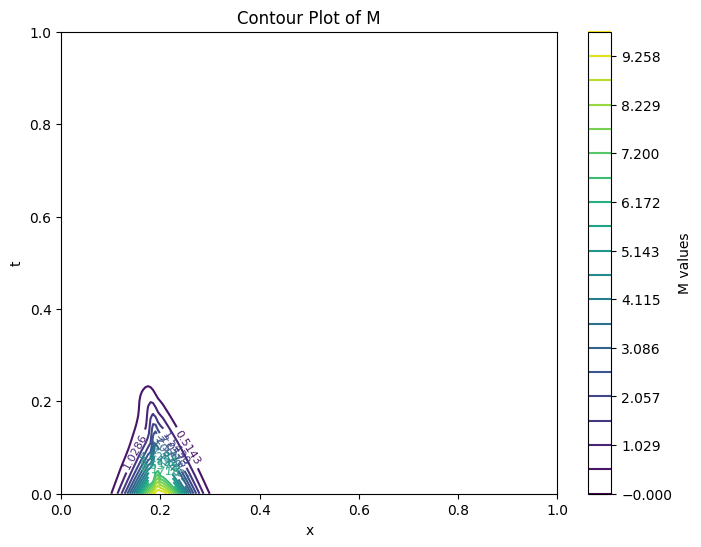

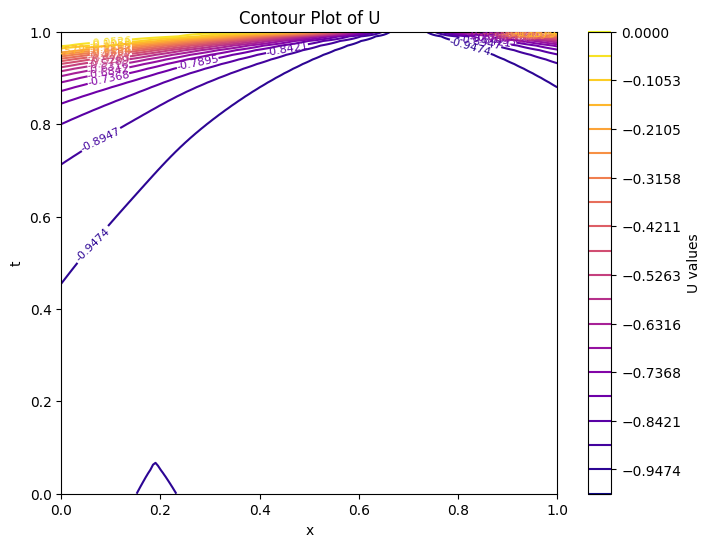

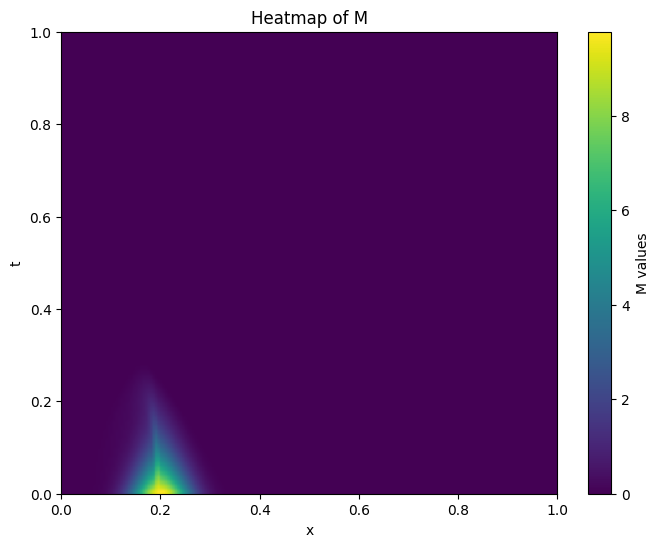

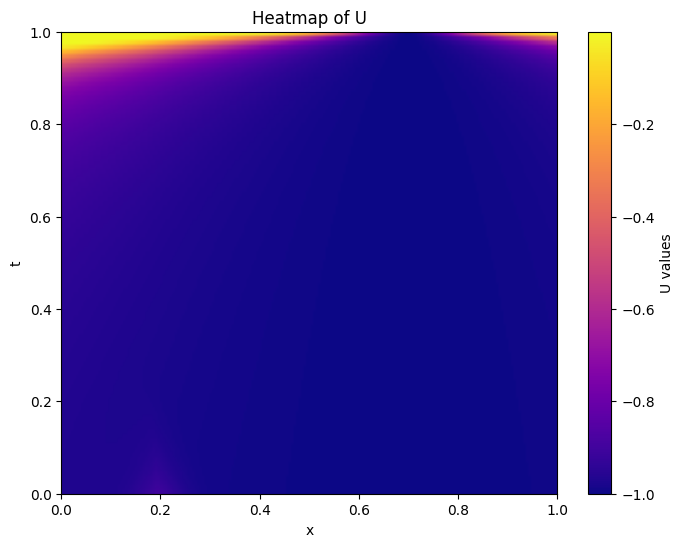

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code from the previous response, all of it goes here) ...

# --- Plotting Contours ---

# 1. Create a meshgrid for x and t
x = np.linspace(0, 1, Nh)  # x values (including boundaries)
t = np.linspace(0, 1, Nt+1)  # t values
X, T = np.meshgrid(x, t)

M = M_history[-1]
U = U_history[-1]

# 2. Plot the contour lines of M
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
contour_levels_M = np.linspace(M.min(), M.max(), 20)  # Adjust number of levels
CS_M = plt.contour(X, T, M.T, levels=contour_levels_M, cmap='viridis')  # .T transposes M to match X, T
plt.clabel(CS_M, inline=True, fontsize=8, fmt='%1.4f')  # Add labels to contour lines, adjusted format
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour Plot of M')
plt.colorbar(label='M values')  # Add a colorbar
plt.show()


# 3. Plot the contour lines of U
plt.figure(figsize=(8, 6))
contour_levels_U = np.linspace(U.min(), U.max(), 20)  # Adjust number of levels
CS_U = plt.contour(X, T, U.T, levels=contour_levels_U, cmap='plasma') # .T transposes U
plt.clabel(CS_U, inline=True, fontsize=8, fmt='%1.4f')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Contour Plot of U')
plt.colorbar(label='U values')
plt.show()

# 4.  (Optional)  Plot M and U as heatmaps.  This is often *more* informative than contours.
plt.figure(figsize=(8, 6))
plt.imshow(M.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of M')
plt.colorbar(label='M values')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(U.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto', cmap='plasma')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of U')
plt.colorbar(label='U values')
plt.show()

In [24]:
M[:,2].sum()

199.99992133521792

In [25]:
M[:,5].sum()

199.99990730917554

Theoretical questions : 
1. M représente la densité de probabilité continue des agents dans l'espace d'états. Ainsi à chaque instant, l'intégrale de la densité de probabilité sur l'espace d'états est constante. 
2. 